In [ ]:
import os

# Importing numpy for linear algebra library
import numpy as np

# Importing matplotlib for graph plotting
import matplotlib.pyplot as plt

# Importing all torchvision required for training such as optimizer and transform
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Importing zipfile to unzip dataset
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Expression" #name of the folder we want to unzip to

# If the image folder doesn't exist, create new file...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip Expression data
with zipfile.ZipFile("/content/data/Expression/Expression.zip", "r") as zip_ref:
        print("Unzipping Expression data...")
        zip_ref.extractall(image_path)

data/Expression directory exists.
Unzipping Expression data...


In [ ]:
image_path = data_path / "Expression"

# Walkthrough the data to check the length of each directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/Expression'.
There are 7 directories and 0 images in 'data/Expression/test'.
There are 0 directories and 797 images in 'data/Expression/test/surprise'.
There are 0 directories and 1825 images in 'data/Expression/test/happy'.
There are 0 directories and 1216 images in 'data/Expression/test/neutral'.
There are 0 directories and 111 images in 'data/Expression/test/disgust'.
There are 0 directories and 960 images in 'data/Expression/test/angry'.
There are 0 directories and 1018 images in 'data/Expression/test/fear'.
There are 0 directories and 1139 images in 'data/Expression/test/sad'.
There are 7 directories and 0 images in 'data/Expression/train'.
There are 0 directories and 3205 images in 'data/Expression/train/surprise'.
There are 0 directories and 7164 images in 'data/Expression/train/happy'.
There are 0 directories and 4982 images in 'data/Expression/train/neutral'.
There are 0 directories and 436 images in 'data/Expression/train/disgust'

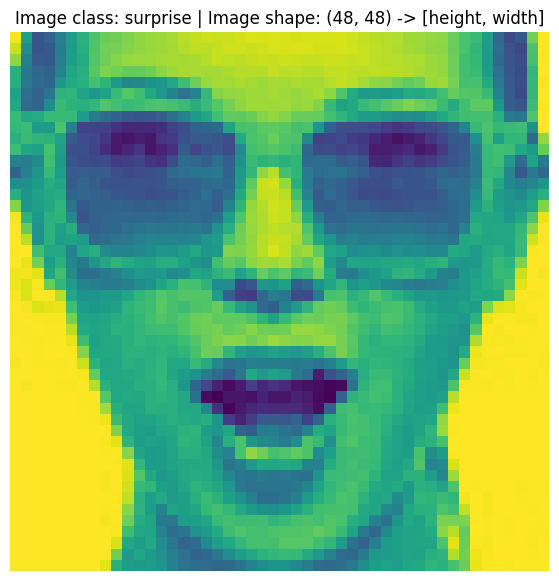

In [ ]:
from PIL import Image
import random

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width]")
plt.axis(False);

In [ ]:
# Image transformation changing to tensor and normalize using mean and standard deviation from imageNet dataset
data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [ ]:
# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "/content/data/Expression/train"
test_dir = image_path / "/content/data/Expression/test"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 28821
    Root location: /content/data/Expression/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 7066
    Root location: /content/data/Expression/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Create iterators for the Data loaded using DataLoader module
batchSize = 64

trainloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

28821
7066


In [ ]:
# Defining the FacialExpressionCNN
class FacialExpressionCNN(nn.Module):
    def __init__(self):
        super(FacialExpressionCNN, self).__init__()

        # 1st Convolutional Layer with 3 channel input, 32 channel output and 5x5 kernel size
        self.conv1 = nn.Conv2d(3, 32, 5)

        # 2nd Convolutional Layer with 32 channel input, 64 channel output and 5x5 kernel size
        self.conv2 = nn.Conv2d(32, 64, 5)

        # 3rd Convolutional Layer with 64 channel input, 128 channel output and 5x5 kernel size
        self.conv3 = nn.Conv2d(64, 128, 5)

        # 1st Fully Connected Layer with 512 inputs and 256 output
        self.fc1 = nn.Linear(128 * 2 * 2, 256)

        # 2nd Fully Connected Layer with 256 inputs and 128 output
        self.fc2 = nn.Linear(256, 128)

        # 3rd Fully Connected Layer with 128 inputs and 7 output (because 7 total classes)
        self.fc3 = nn.Linear(128, 7)

        # Max pooling function with kernel_size = 2, stride = 2
        self.pool = nn.MaxPool2d(2, 2)

        # ReLU activation function for each layers
        self.relu = nn.ReLU()


    # Each Convolutional Layers will go through ReLU activation function and max pooling
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initializing the model using the CNN built above
model = FacialExpressionCNN()

# Initializing the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Moving the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Printing the model summary
print(model)

FacialExpressionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [ ]:
# Training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training function
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f'Train Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Testing function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(avg_loss)
    val_accuracies.append(accuracy)
    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

In [ ]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 25
for epoch in range(1, num_epochs + 1):
    train(model, device, trainloader, criterion, optimizer, scheduler, epoch)
    test(model, device, testloader, criterion)

Train Epoch: 1, Loss: 1.6249, Accuracy: 34.69%
Test set: Average loss: 0.0226, Accuracy: 3093/7066 (43.77%)
Train Epoch: 2, Loss: 1.3426, Accuracy: 48.04%
Test set: Average loss: 0.0198, Accuracy: 3673/7066 (51.98%)
Train Epoch: 3, Loss: 1.2044, Accuracy: 54.05%
Test set: Average loss: 0.0194, Accuracy: 3721/7066 (52.66%)
Train Epoch: 4, Loss: 1.0949, Accuracy: 58.39%
Test set: Average loss: 0.0184, Accuracy: 3989/7066 (56.45%)
Train Epoch: 5, Loss: 0.9961, Accuracy: 62.36%
Test set: Average loss: 0.0186, Accuracy: 3967/7066 (56.14%)
Train Epoch: 6, Loss: 0.8949, Accuracy: 66.24%
Test set: Average loss: 0.0194, Accuracy: 3975/7066 (56.26%)
Train Epoch: 7, Loss: 0.7832, Accuracy: 70.85%
Test set: Average loss: 0.0191, Accuracy: 4029/7066 (57.02%)
Train Epoch: 8, Loss: 0.6715, Accuracy: 75.22%
Test set: Average loss: 0.0212, Accuracy: 4069/7066 (57.59%)
Train Epoch: 9, Loss: 0.5604, Accuracy: 79.48%
Test set: Average loss: 0.0228, Accuracy: 4016/7066 (56.84%)
Train Epoch: 10, Loss: 0.455

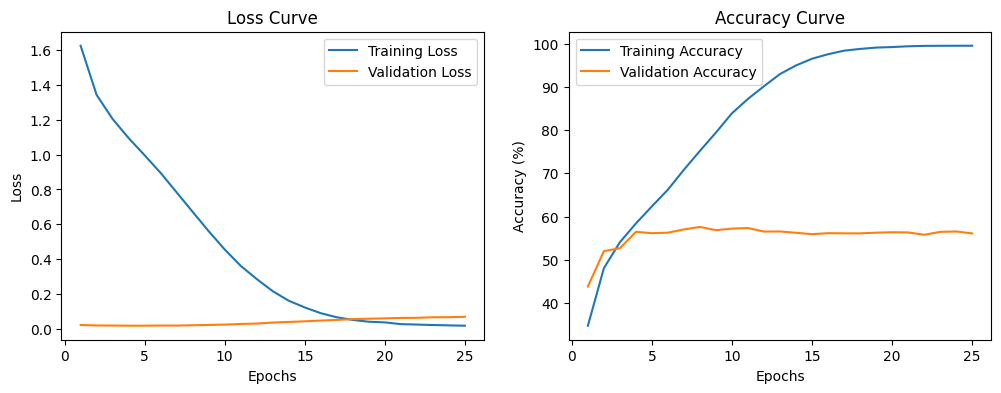

In [ ]:
# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()